In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
df = '/content/df'
batch_size = 8
learning_rate = 0.001
epochs = 15
img_size = 500

In [ ]:
# leaving this here if you're running on a gpu sri
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using device: cpu


In [ ]:
# 1. DATA PREPROCESSING & LOADING
# ==========================================


transform = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = datasets.ImageFolder(root=df, transform=transform)

# Determine split sizes (80% Train, 20% Validation)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

# Perform the split
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Classes detected: {full_dataset.classes}")
print(f"Training images: {len(train_dataset)}")
print(f"Validation images: {len(test_dataset)}")


Classes detected: ['0', '1']
Training images: 36
Validation images: 10


In [ ]:
# ==========================================
# 2. CNN ARCHITECTURE
# ==========================================

class RazorbackCNN(nn.Module):
    def __init__(self):
        super(RazorbackCNN, self).__init__()

        # Block 1: Input 3x500x500 -> Output 16x250x250
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Block 2: Output 32x125x125
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)

        # Block 3: Output 64x62x62
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

        # Block 4: Output 128x31x31
        # We add a 4th block because 500x500 is a large input size
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # Activation function
        self.relu = nn.ReLU()

        # Flatten for fully connected layers
        self.flatten = nn.Flatten()

        # Fully Connected Layers
        # Input size: 128 channels * 31 * 31 spatial dimensions
        self.fc1 = nn.Linear(128 * 31 * 31, 256)
        self.dropout = nn.Dropout(0.5) # overfitting --> talk about this later
        self.fc2 = nn.Linear(256, 2)   #2 classes (Official vs Not Official)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))

        # Flatten and pass through Dense layers
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = RazorbackCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Starting Training...
Epoch [1/15], Loss: 0.9937
Epoch [2/15], Loss: 0.7248
Epoch [3/15], Loss: 0.5542
Epoch [4/15], Loss: 0.4659
Epoch [5/15], Loss: 0.2678
Epoch [6/15], Loss: 0.2767
Epoch [7/15], Loss: 0.2652
Epoch [8/15], Loss: 0.2102
Epoch [9/15], Loss: 0.1329
Epoch [10/15], Loss: 0.1427
Epoch [11/15], Loss: 0.1179
Epoch [12/15], Loss: 0.1179
Epoch [13/15], Loss: 0.0457
Epoch [14/15], Loss: 0.1662
Epoch [15/15], Loss: 0.0605
Loss plot saved as training_loss.png


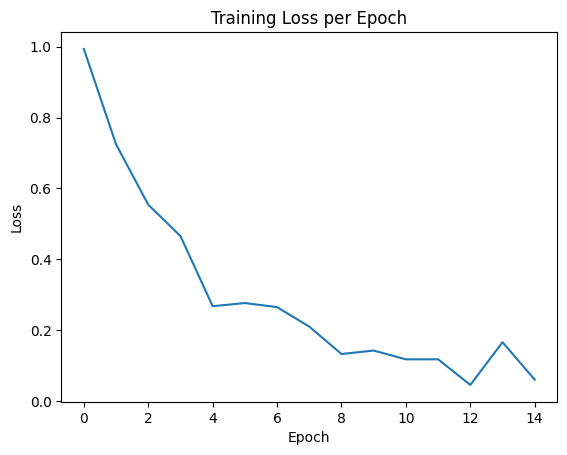

In [ ]:
# ==========================================
# 3. TRAINING LOOP
# ==========================================

print("\nStarting Training...")
train_losses = []

for epoch in range(epochs):
    model.train() # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss for this epoch
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

plt.figure()
plt.plot(train_losses)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('training_loss.png')
print("Loss plot saved as training_loss.png")

In [ ]:
# ==========================================
# 4. EVALUATION
# ==========================================

print("\nEvaluating on Validation Set...")
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f'Validation Accuracy: {accuracy:.2f}%')

# Detailed Metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


Evaluating on Validation Set...


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation Accuracy: 80.00%

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80         5
           1       0.80      0.80      0.80         5

    accuracy                           0.80        10
   macro avg       0.80      0.80      0.80        10
weighted avg       0.80      0.80      0.80        10



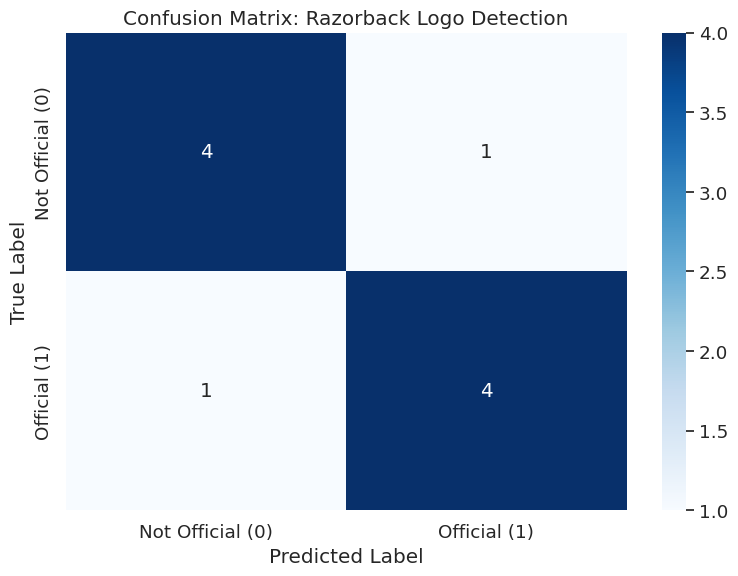

Confusion matrix saved as 'confusion_matrix.png'


In [ ]:
# 1. Calculate the Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

# 2. Setup the Plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)

# 3. Create the Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Official (0)', 'Official (1)'],
            yticklabels=['Not Official (0)', 'Official (1)'])

# 4. Add Labels
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Razorback Logo Detection')

# 5. Save for PowerPoint
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300) # dpi=300 makes it high resolution
plt.show()

How did you create your dataset and determine split of official logo versus not official logo?

-----------
we did a 50/50 split of images that were official and unofficial with a 80/20 test and training data. With a split dataset this allowed us to have a wide variety of official and unofficial images allowing the model to have a greater idea of what to look for.


Why did you choose the specific architecture for the final model?

----------

Architecture: We built a 4-layer CNN.


We used 4 layers because the input size of (500x500) is pretty large large. A 2-layer CNN would result in a massive flattened layer, which caused memory errors and worse results.

We used 4 Convolutional/Pooling blocks to reduce these dimensions from 500 -> 250 -> 125 -> 62 -> 31 before flattening.


Features:

We used ReLU activation for non-linearity and Dropout in the fully connected layers to prevent the model from relying too heavily on any single pixel pattern(s).

 How did you monitor and mitigate overfitting?

----------

Monitoring: We tracked the Training Loss. If the training loss approaches 0.0 but the validation accuracy drops or stagnates, we know we are overfitting.


Mitigation:

1) Dropout: We added a Dropout(0.5) layer, which randomly disables 50% of the neurons during training, forcing the network to learn robust features.


2) Simplicity: We kept the number of filters (16, 32, 64, 128) relatively low compared to massive networks like ResNet, preventing the model from having enough capacity to simply "memorize" the 40 training images.

What future efforts do you recommend to improve model performance?

--------

Better and more clear images for sure. We had very good images for 0 (unofficial) but more could always be better for the officials (1).

We would eventually start scaling the unofficial ones to be less of cheap knockoffs and try to find some that really try to perfectly imitate the official logo as well.

Data augmentation would also work very well here. we can expand our current data by getting varying angles and rotations of it to get better generalization.
